# IANNwTF HW 4
## Group 10

The following contains our solution to the exercises in IANNwTF HW 04. A Jupyter notebook versus a module format was chosen this time for purposes of organization.

### Assigment 1: Reviews
We review the homeworks for Groups 15 and 32.

### Assignment 2: MNIST Math

### 2.1 Preparing the MNIST Math Dataset

In [57]:
# Needed Imports
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense
import tqdm
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [58]:
# 2.1 Load Dataset
(train_ds, test_ds), ds_info = tfds.load ('mnist', split =['train', 'test'], as_supervised = True, with_info = True)

# Info on the dataset (refresher)
# print("ds_info: \n", ds_info)
# tfds.show_examples(train_ds, ds_info)

In [59]:
# 2.2 Data Pipeline
def prepare_data(dataset, batchsize):

    '''
    :param dataset: the dataset to be prepared for input into the network
    :param batchsize: the desired batchsize
    :return: 2 datasets, one each for each of the math problems defined (see below), created after the original database was preprocessed with the
    steps below
    '''

    # Step 1 - General Preprocessing

    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # flatten the images into vectors
    dataset = dataset.map(lambda img, target: (tf.reshape(img, (-1,)), target))

    # input normalization, just bringing image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, target: ((img / 128.) - 1., target))
    
    # create one-hot targets
    dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # Step 2 - Pairing Data Tuples & Respective Parameterized Targets

    # create a dataset that contains 2000 samples from the overall dataset paired with 2000 other samples
    data = tf.data.Dataset.zip((dataset.shuffle(2000), dataset.shuffle(2000)))

    # create the dataset for the first math problem (a + b >= 5) - remembering to cast to int versus boolean!
    greateqfive = data.map(lambda x1, x2: (x1[0], x2[0], x1[1]+x2[1]>=5))
    greateqfive = greateqfive.map(lambda x1, x2, t: (x1, x2, tf.cast(t, tf.int32)))

    # create the dataset for the second math problem (a - b = y)
    subtr = data.map(lambda x1, x2: (x1[0], x2[0], x1[1]-x2[1]))

    # Step 3 - Batching & Prefetching
    greateqfive = greateqfive.batch(batchsize)
    greateqfive = greateqfive.prefetch(tf.data.AUTOTUNE)
    subtr = subtr.batch(batchsize)
    subtr = subtr.prefetch(tf.data.AUTOTUNE)

    # return BOTH datasets
    return greateqfive, subtr

In [60]:
# Check data pipeline by examining one example from each of the four created datasets (one for each math problem for train and test)

train_ds_gef, train_ds_subtr = prepare_data(train_ds, batchsize = 32)
test_ds_gef, test_ds_subtr = prepare_data(test_ds, batchsize = 32)

for img1, img2, label in train_ds_gef.take(1):
    print(img1.shape, img2.shape, label.shape)

for img1, img2, label in train_ds_subtr.take(1):
    print(img1.shape, img2.shape, label.shape)

for img1, img2, label in test_ds_gef.take(1):
    print(img1.shape, img2.shape, label.shape)

for img1, img2, label in test_ds_subtr.take(1):
    print(img1.shape, img2.shape, label.shape)


(32, 784) (32, 784) (32, 10)
(32, 784) (32, 784) (32, 10)
(32, 784) (32, 784) (32, 10)
(32, 784) (32, 784) (32, 10)


In [61]:
# Initiate the logs and metrics
config_name= "config_name"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time}/train"
val_log_path = f"logs/{config_name}/{current_time}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)

# Initiate epochs and learning rate as global variables
epochs = 5 # 10
learning_rate = 0.1 # 0.01

# Define arrays for saving values for later visualization
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

### Assignment 3: Building Shared Weight Models

In [62]:
class MyModel(tf.keras.Model):
    def __init__(self, numlayers, subtask, optimizer):

        '''
        param: numlayers - the desired number of hidden layers
        param: subtask - the subtask the network is being asked to solve (relevant for output layer)
        param: optimizer - the optimizer to be used
        '''

        super(MyModel, self).__init__()

        self.optimizer = optimizer
        self.subtask = subtask

        self.layerlist = [Dense(layers, activation="relu") for layers in range(numlayers)]

        if subtask == 0:
            self.output_layer = Dense(units=1, activation=tf.nn.sigmoid)
            self.loss_function = tf.keras.losses.BinaryCrossentropy()
        elif subtask == 1:
            self.output_layer = Dense(units=10, activation=tf.nn.softmax) # not 10 units, since the label.shape is (32,) not (32,10)
            self.loss_function = tf.keras.losses.MeanSquaredError()

        self.metrics_list = [
                    tf.keras.metrics.Mean(name="loss"),
                    tf.keras.metrics.BinaryAccuracy(name="acc"), # only for subtask 0, not for subtask 1
                    #tf.keras.metrics.TopKCategoricalAccuracy(3,name="top-3-acc")
                    ]

    @tf.function
    def __call__(self, input: tuple, training = False):

        # feed both inputs separately into the first layer, then concatenate the results before passing activity through the rest of the network UP TO the output layer
        for layer in range(len(self.layerlist)):
             if layer == 0:
                 i1 = self.layerlist[layer](input[0])
                 i2 = self.layerlist[layer](input[1])
                 i = tf.concat([i1, i2], axis=1)   # e.g. axis=1: (32,784) + (32,784) -> (32, 1568)
             else:
                 i = self.layerlist[layer](i)

        # run the activity through the output layer after it passes through the hidden layers
        output = self.output_layer(i)

        return output

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function
    def train_step(self, input):
        img1, img2, label = input

        with tf.GradientTape() as tape:
            prediction = self((img1, img2), training=True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update loss metric
        self.metrics[0].update_state(loss)

        # for all metrics except loss, update states (accuracy etc.)
        for metric in self.metrics[1:]:
            metric.update_state(label, prediction) # + tf.reduce_sum(self.losses)

        # Return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, input):

        img1, img2, label = input

        prediction = self((img1, img2), training=False)
        loss = self.loss_function(label, prediction) # + tf.reduce_sum(self.losses)

        # update loss metric
        self.metrics[0].update_state(loss)

        # for accuracy metrics:
        for metric in self.metrics[1:]:
            metric.update_state(label, prediction)

        # Return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


### Assignment 4: Training the Networks

In [63]:
def training(numlayers, subtask, optimizer):
    '''
    :param: numlayers: the number of layers desired in the network to be trained
    :param subtask: defines the subtask to be solved, 0 is a + b >= 5, 1 is a - b = y
    :param optimizer: the optimizer function to use
    :return:
    '''

    # Initiate a model with the requested parameters
    network = MyModel(numlayers, subtask, optimizer)

    # Initialize the train and test datasets, and the loss function, based on the subtask
    if subtask == 0:
        train = train_ds_gef
        test = test_ds_gef

    else:
        train = train_ds_subtr
        test = test_ds_subtr

    # Train the model
    for epoch in range(epochs):
        print(f"Epoch {epoch}")

        for data in tqdm.tqdm(train, position=0, leave=True):
            metrics = network.train_step(data)

            with train_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # Piper Attempt at Retrieve Mets for Vis
        #train_losses.append(network.metrics[0].result())
        #train_accuracies.append(network.metrics[1].result())

        # print the end acc and loss
        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                train_losses.append(value.numpy())
            elif key == "acc":
                train_accuracies.append(value.numpy())

        # reset metrics for next round
        network.reset_metrics()

        # Testing
        for data in test:
            metrics = network.test_step(data)

            # log the accs and losses
            with val_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

        # Piper Attempt at Retrieve Mets for Vis
        #test_losses.append(network.metrics[2].result())
        #test_accuracies.append(network.metrics[3].result())

        # print the end acc and loss
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                val_losses.append(value.numpy())
            elif key == "acc":
                val_accuracies.append(value.numpy())

        # reset all metrics
        network.reset_metrics()

        #return train_losses,train_accuracies,test_losses,test_accuracies


In [64]:
training(2, 1, tf.keras.optimizers.Adam())

Epoch 0


100%|██████████| 1875/1875 [00:11<00:00, 163.19it/s]


['train_loss: 0.1898764669895172', 'train_acc: 0.8201299905776978']
['val_loss: 0.1899721622467041', 'val_acc: 0.8200399875640869']
Epoch 1


100%|██████████| 1875/1875 [00:09<00:00, 196.92it/s]


['train_loss: 0.1900428682565689', 'train_acc: 0.8199633359909058']
['val_loss: 0.18947292864322662', 'val_acc: 0.8205199837684631']
Epoch 2


100%|██████████| 1875/1875 [00:08<00:00, 218.41it/s]


['train_loss: 0.1900399625301361', 'train_acc: 0.8199666738510132']
['val_loss: 0.190471351146698', 'val_acc: 0.8195400238037109']
Epoch 3


100%|██████████| 1875/1875 [00:08<00:00, 209.41it/s]


['train_loss: 0.19020633399486542', 'train_acc: 0.8198000192642212']
['val_loss: 0.19073088467121124', 'val_acc: 0.8192600011825562']
Epoch 4


 55%|█████▍    | 1028/1875 [00:05<00:04, 205.19it/s]


KeyboardInterrupt: 

In [ ]:
# Train a model to solve the first math problem
training(2, 0, tf.keras.optimizers.Adam())
adamlist_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(2, 0, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0))
SDG_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(2, 0, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.5))
SDG_mom_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(2, 0, tf.keras.optimizers.RMSprop())
RMS_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(2, 0, tf.keras.optimizers.Adagrad())
Adagrad_0 = [train_losses, train_accuracies, val_losses, val_accuracies]


In [ ]:
# Train a model to solve the first math problem
training(2, 1, tf.keras.optimizers.Adam())
adamlist_1 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(2, 0, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0))
SDG_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(2, 0, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.5))
SDG_mom_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(2, 0, tf.keras.optimizers.RMSprop())
RMS_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(2, 0, tf.keras.optimizers.Adagrad())
Adagrad_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

train_losses: [0.5248539, 0.44129115, 0.4380492, 0.43805572, 0.43716604, 17.613567, 17.681034, 17.7534, 17.810934, 17.7327, 0.5271127, 0.44131684, 0.4377605, 0.43741772, 0.4374252]
train_accuracies: [0.83998334, 0.84075, 0.841, 0.84098333, 0.8415167, 0.0898, 0.0892, 0.090966664, 0.08918333, 0.08958333, 0.8401833, 0.8408667, 0.8411667, 0.84136665, 0.84136665]
val_losses: [0.45374647, 0.43982127, 0.43991643, 0.43541378, 0.44091251, 17.570387, 17.900259, 17.895267, 17.785244, 17.629494, 0.45314515, 0.430802, 0.44041282, 0.44805124, 0.4422544]
val_accuracies: [0.8382, 0.8401, 0.8398, 0.8427, 0.8392, 0.09, 0.0891, 0.0845, 0.0851, 0.0885, 0.8394, 0.8453, 0.8395, 0.835, 0.8388]


In [ ]:
fig = plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(val_losses)
line3, = plt.plot(train_accuracies)
line4, = plt.plot(val_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3, line4), ("Training Loss", "Test Loss", "Training Accuracy", "Test Accuracy"))
# fig.savefig("Title-Of-The-Figure") 
plt.show()

In [ ]:
# Train a model to solve the second math problem
training(2, 1, tf.keras.optimizers.Adam())
#training(2, 1, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0))
#training(2, 1, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.5))
#training(2, 1, tf.keras.optimizers.RMSprop())
#training(2, 1, tf.keras.optimizers.Adagrad())

Epoch 0


100%|██████████| 1875/1875 [00:08<00:00, 217.80it/s]


['train_loss: 17.613567352294922', 'train_acc: 0.08980000019073486']
['val_loss: 17.57038688659668', 'val_acc: 0.09000000357627869']
Epoch 1


100%|██████████| 1875/1875 [00:08<00:00, 214.47it/s]


['train_loss: 17.681034088134766', 'train_acc: 0.08919999748468399']
['val_loss: 17.900259017944336', 'val_acc: 0.08910000324249268']
Epoch 2


100%|██████████| 1875/1875 [00:09<00:00, 204.54it/s]


['train_loss: 17.753400802612305', 'train_acc: 0.09096666425466537']
['val_loss: 17.895267486572266', 'val_acc: 0.08449999988079071']
Epoch 3


100%|██████████| 1875/1875 [00:10<00:00, 182.78it/s]


['train_loss: 17.81093406677246', 'train_acc: 0.08918333053588867']
['val_loss: 17.78524398803711', 'val_acc: 0.08510000258684158']
Epoch 4


100%|██████████| 1875/1875 [00:09<00:00, 189.54it/s]


['train_loss: 17.73270034790039', 'train_acc: 0.08958332985639572']
['val_loss: 17.629493713378906', 'val_acc: 0.0885000005364418']


**Accuracy does initially seem to go up over the epochs, but then drops again. But then this is the harder task I think. Visualization should be a matter of pulling out the metric results into the lists we created so we can use those lists for the next part. I tried this with the code I added above (marked as my attempt), but no luck.**

### Assignment 5 - Experiments

Run training w/ classic SGD (no momentum)

Run training w/ Adam

Run training w/ SGD + Momentum

Run training w/ RMSrop

Run training w/ AdaGrad

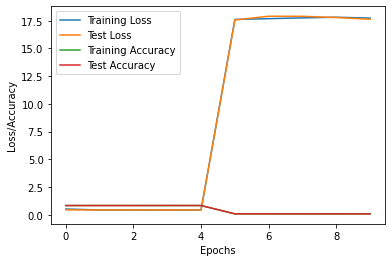

In [ ]:
fig = plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(val_losses)
line3, = plt.plot(train_accuracies)
line4, = plt.plot(val_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3, line4), ("Training Loss", "Test Loss", "Training Accuracy", "Test Accuracy"))
# fig.savefig("Title-Of-The-Figure")
plt.show()

Wooki) in QnA

1. do we need to have a code that shows plots from different optimizers with one click 
or do we just need to save the plots from different optimizers after running multiple codes?

2. the loss/acc for subtask 1 is off. maybe output unit should be 10 instead of 1 but that gives a dimension difference error.

3. preprocessing in hw5

4. input sizes throughout cnn in hw 5